# Gas Predict

Predict gas fees for the next X hours to be able to judge how likely certain lows are going to happen.

We're especially interested in predicting the next low gas fees as well as their probabilities.

To download the data, we use `run-download.sh`.

### Read Data

In [97]:
import json

data_file = "data/data.json"

with open(data_file,"r") as f:
    data_json = json.load(f)

oN = len(data_json)
print(oN,"blocks")

158800 blocks


In [98]:
import numpy as np

In [99]:
# Convert to a format where we have an array with fields:
# blocknr, day in week, hour in day, minute in hour, second in minute

# Essentially, given a few days of gas prices, we want to predict how it's going to continue.

M = 6
# fields: blockr, gas, timestamp, median over window, minimum over window, 15%-quantile over window
# each block will be centered in its window and not preceding it. this is, because we want all these
# rolling averages to have the spikes etc. on the same block
window_size = 30*60//12 # x minutes = x*60 seconds = x*60/12 blocks
odata = np.zeros((oN, M),dtype=np.int64)

i = 0
for k, v in data_json.items():
    fee = v["fee"]
    odata[i] = np.array([k,int(fee), v["t"], fee, fee, fee],dtype=np.int64)
    i = i + 1
    
# sort by time (newest last)
odata = odata[odata[:,0].argsort()]

print("Calculating rolling windows...")
for i in range(oN):
    if i < window_size:
        continue
    m = i - window_size + window_size // 2
    odata[m,3] = np.median(odata[(i-window_size):i,1])
    odata[m,4] = np.min(odata[(i-window_size):i,1])
    odata[m,5] = np.quantile(odata[(i-window_size):i,1], 0.15)
    
print("Done.")
    
print(odata[:12])
print(odata[(oN-12):])

Calculating rolling windows...
Done.
[[  16841022         34 1678977191         34         34         34]
 [  16841023         33 1678977203         33         33         33]
 [  16841024         33 1678977215         33         33         33]
 [  16841025         32 1678977227         32         32         32]
 [  16841026         32 1678977239         32         32         32]
 [  16841027         31 1678977251         31         31         31]
 [  16841028         32 1678977263         32         32         32]
 [  16841029         32 1678977275         32         32         32]
 [  16841030         32 1678977287         32         32         32]
 [  16841031         31 1678977299         31         31         31]
 [  16841032         33 1678977311         33         33         33]
 [  16841033         35 1678977323         35         35         35]]
[[  16999810         20 1680909575         20         20         20]
 [  16999811         19 1680909587         19         19         

Rather than predicting the gas price, it makes more sense to create moving median, minimum and x quantile (e.g. 15%%) and predict that.
Otherwise the high spikes in gas price will dominate the predictions even though we're rather interested in the lows.

---

## Gas Price with moving median/minimun/quantile(15%)

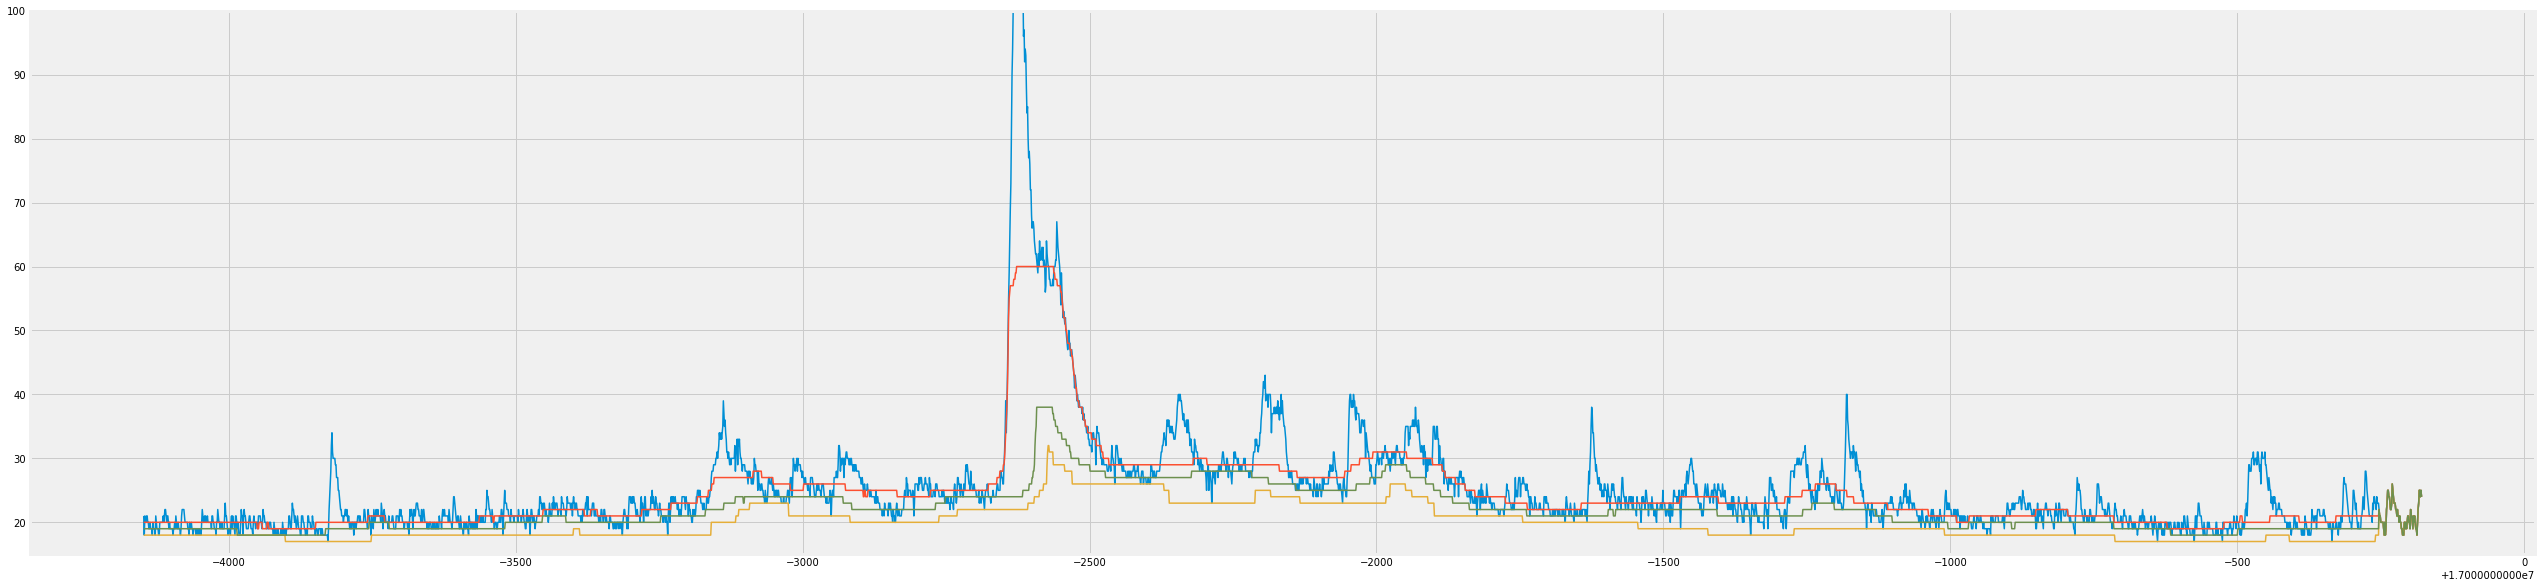

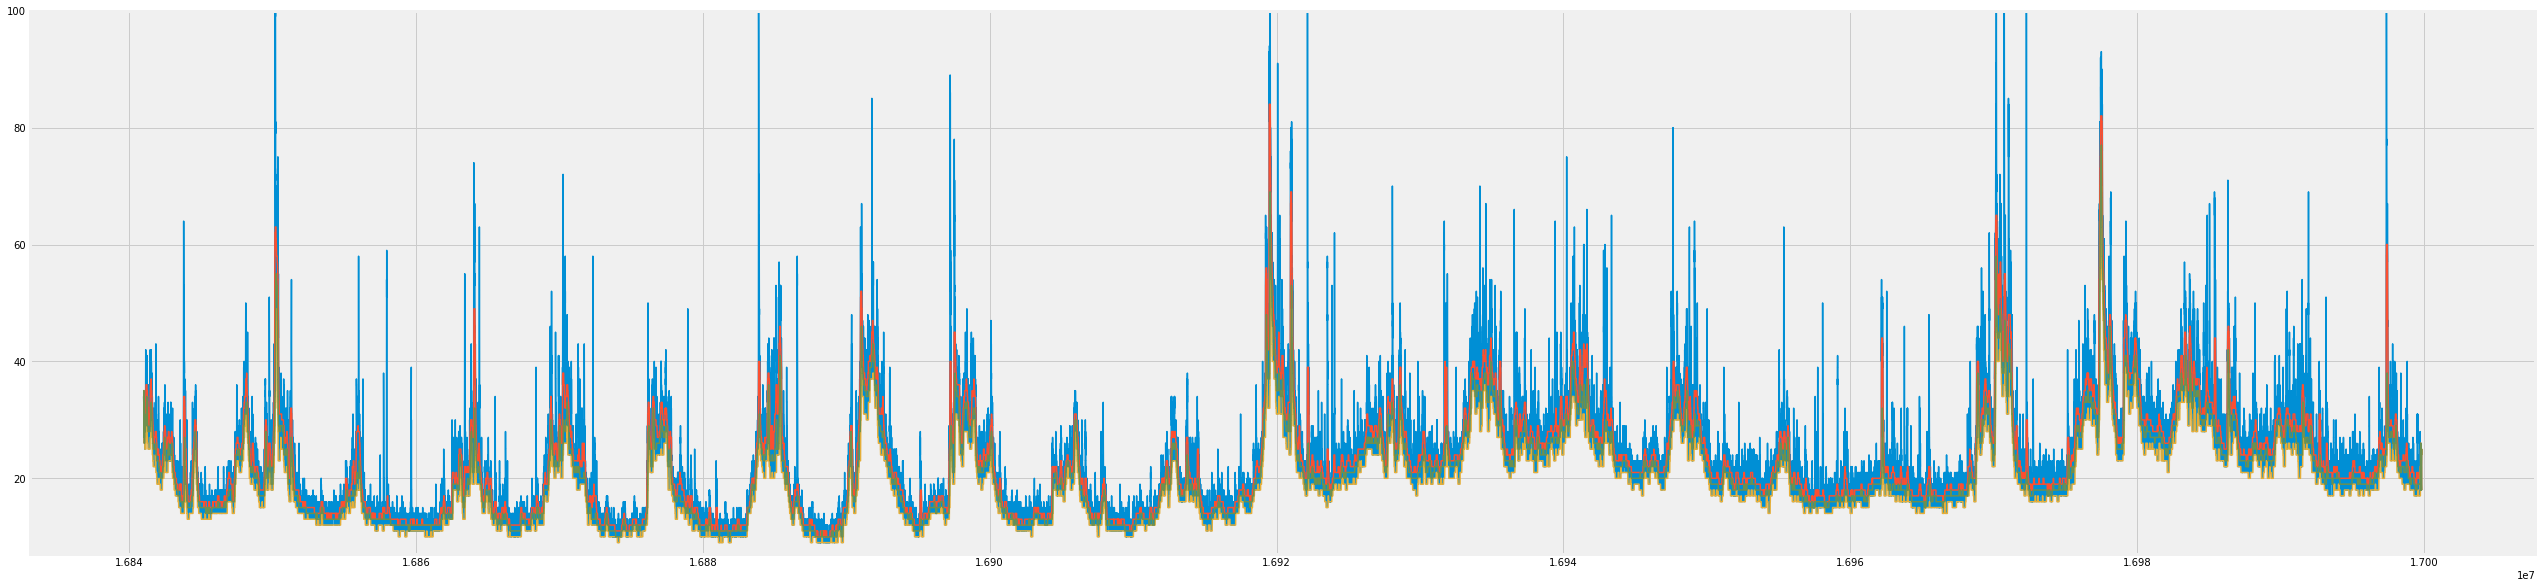

In [100]:
import matplotlib.pyplot as plt

showN = oN // 40

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1])
plt.plot(odata[-showN:,0],odata[-showN:,3])
plt.plot(odata[-showN:,0],odata[-showN:,4])
plt.plot(odata[-showN:,0],odata[-showN:,5])
plt.ylim(15,100)
plt.show()

showN = oN

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1])
plt.plot(odata[-showN:,0],odata[-showN:,3])
plt.plot(odata[-showN:,0],odata[-showN:,4])
plt.plot(odata[-showN:,0],odata[-showN:,5])
plt.ylim(7,100)
plt.show()


## Forcasting

Used this tutorial/template:
https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [101]:
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

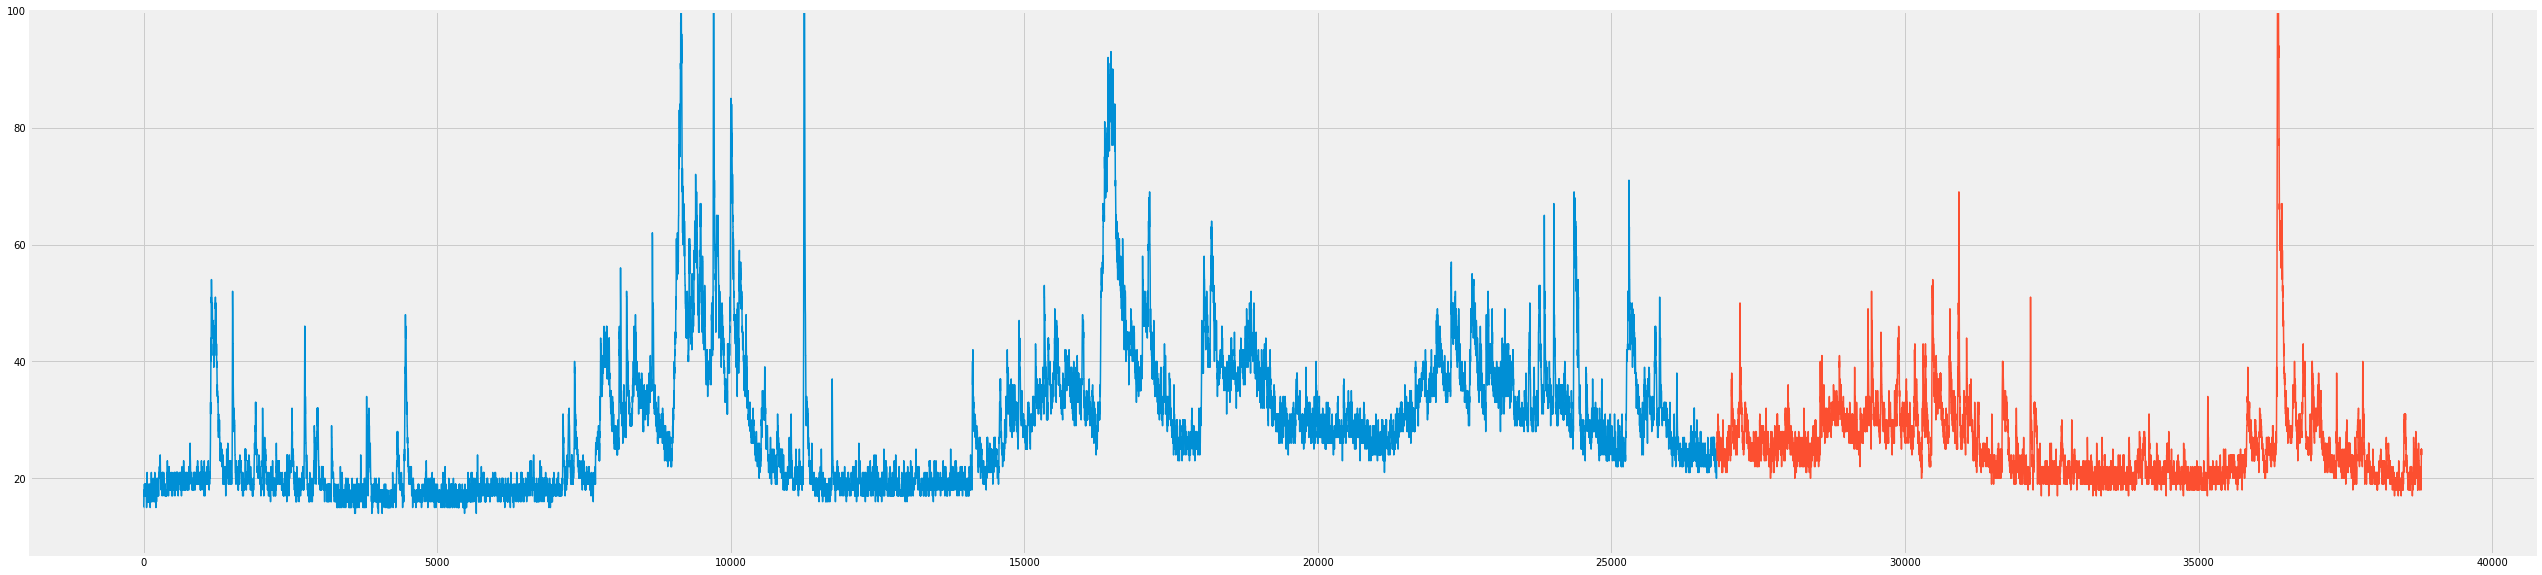

In [102]:
# test train split

nBlockTest = 12000
skip = 120000
oNt = oN - skip

data_train = pd.DataFrame(odata[skip:-nBlockTest, [1,3,4,5]]) # exclude blocknr and timestamp from data
data_test  = pd.DataFrame(odata[-nBlockTest:, [1,3,4,5]])
cols = ["Gas", "Median", "Minimun", "Quantile"]
data_train.columns = cols
data_test.columns = cols

                          
plt.figure(figsize=(40,10))
plt.plot(np.arange(oNt-nBlockTest),data_train["Gas"])
plt.plot(np.arange(nBlockTest)+(oNt-nBlockTest),data_test["Gas"])
plt.ylim(7,100)
plt.show()

In [116]:
pred_past_window = 100

forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=1337),
    lags=pred_past_window
)

forecaster.fit(y=data_train["Quantile"])
# todo: ^ this seems to also use the moving windows, which we shouldn't be able to use, as they contain new information from the future!
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=1337) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] 
Transformer for y: None 
Transformer for exog: None 
Window size: 100 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 26799] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1

In [117]:
steps = 1000
predictions = forecaster.predict(steps=steps)
predictions.head(5)

26800    23.000844
26801    23.000924
26802    23.000919
26803    23.000491
26804    22.999974
Name: pred, dtype: float64

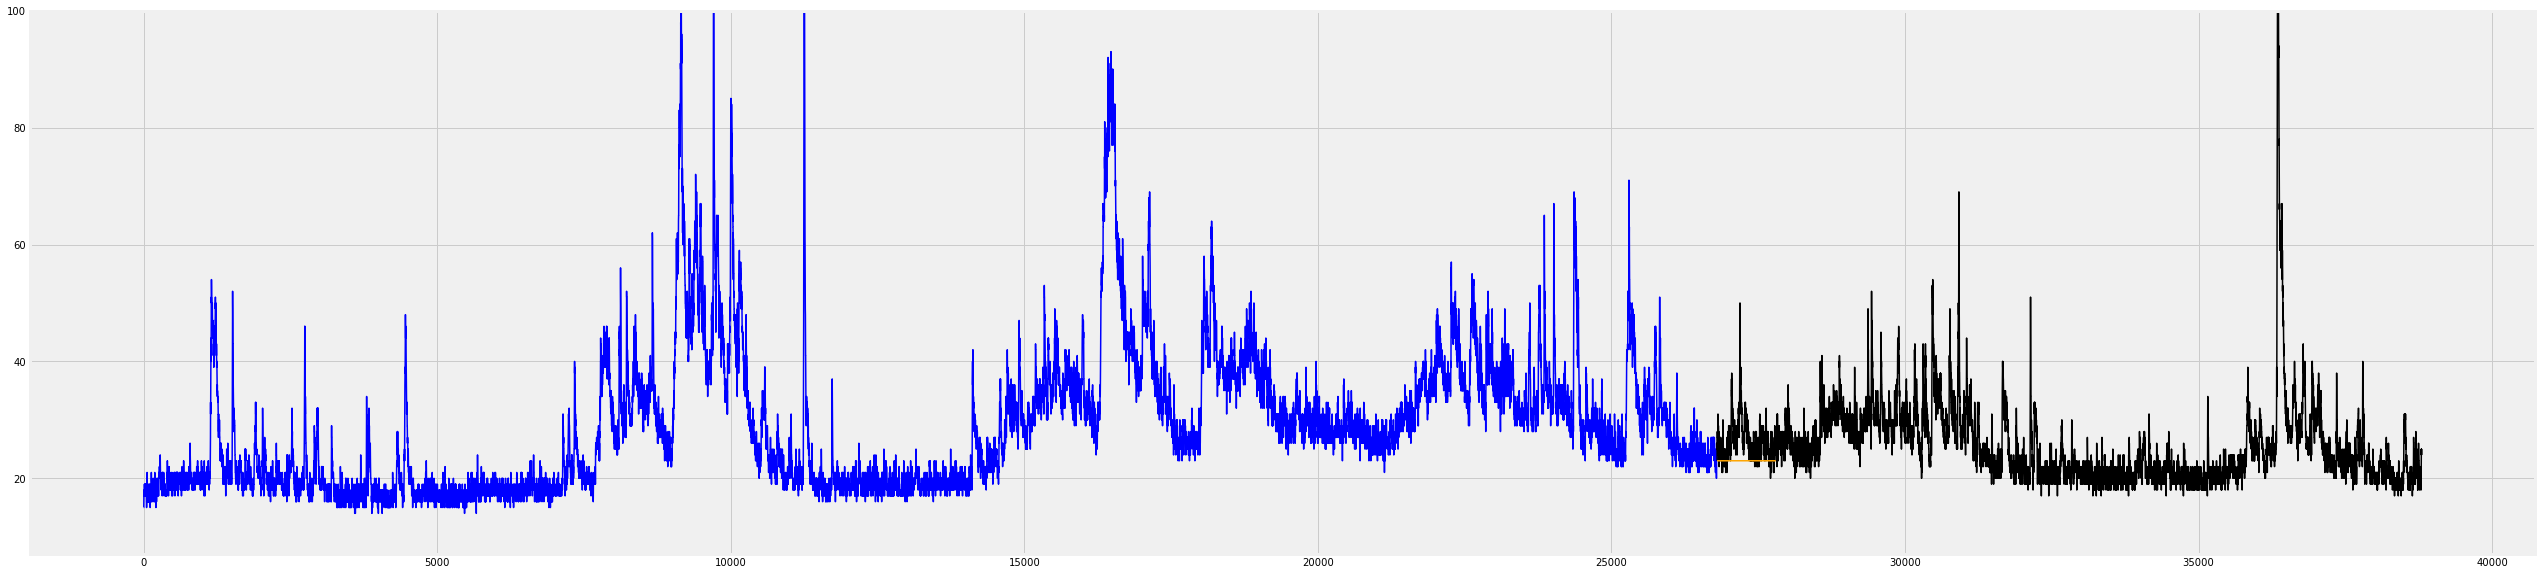

In [118]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(oNt-nBlockTest),data_train["Gas"],"b")
plt.plot(np.arange(nBlockTest)+(oNt-nBlockTest),data_test["Gas"],"black")
plt.plot(np.arange(steps)+(oNt-nBlockTest),predictions,"orange")
plt.ylim(7,100)
plt.show()